# Installing and Importing Libraries

In [2]:
!pip install monai seaborn google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.3 MB/s eta 0:00:00


In [5]:
import os
import h5py
import zipfile
import monai
import torch
import time
import io
import cv2
import json
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from typing import cast
from tqdm import tqdm
from pathlib import Path

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from monai.networks.utils import one_hot
from monai.networks.nets import ResNetFeatures, ViT, resnet10, resnet18, resnet34, resnet50, resnet101, resnet152, resnet200
from monai.visualize import GradCAMpp, GradCAM
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged, Resized,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d, RandShiftIntensityd,
    RandAffined, RandZoomd, RandGaussianNoised, Compose, EnsureTyped, ToTensord, ScaleIntensity
)
from google.cloud import storage

In [ ]:
!gsutil -m cp -r gs://oai_dataset/* .

Показано результат, скорочений до останніх рядків (5000).
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9522950_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9523022_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9523138_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9523523_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9523641_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9523742_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9524398_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://oai_dataset/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/9524666_00m_SAG_IW_TSE_LEFT.hdf5...
Copying gs://o

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!cp -r "/content/drive/MyDrive/RAI_models" "/content/models"

Mounted at /content/drive/


# Data Preprocessing

In [4]:
DEVICE = "cuda"
# DEVICE = "cpu"
EXP_NAME = ''
MULTIMODAL_P = True
NUM_CLASSES = 2
MRI_HEIGHT = 128
MRI_WIDTH = 128
MRI_DEPTH = 35
MLP_HIDDEN = 8
MLP_OUTPUT = 4
RESNET_OUTPUT = 124
GRADCAM_IDX = 15
ORIG_HEIGHT = 444
ORIG_WIDTH = 448
NUM_EPOCHS = 40
RESNET_LR = 1e-4
MLP_LR = 1e-3
FC_LR = 1e-3
# LR = 0.001
BS = 5
# STEP_SIZE = 2
# GAMMA = 0.1
GRADCAM_LAYERS = {
    'resnet_10': 'mri_resnet.resnet.layer4.0.conv2',
    'resnet_18': 'mri_resnet.resnet.layer4.1.conv2',
    'resnet_34': 'mri_resnet.resnet.layer4.2.conv2',
    'resnet_50': 'mri_resnet.resnet.layer4.2.conv3',
    'resnet_101': 'mri_resnet.resnet.layer4.2.conv3',
    'resnet_152': 'mri_resnet.resnet.layer4.2.conv3',
    'resnet_200': 'mri_resnet.resnet.layer4.2.conv3'
}



MRI_LEFT_PATH = f"/content/FEMAI-Knee/OAI_00m_SAG_IW_TSE_LEFT/SAG_IW_TSE_LEFT/00m/"
MRI_RIGHT_PATH = f"/content/FEMAI-Knee/OAI_00m_SAG_IW_TSE_RIGHT/SAG_IW_TSE_RIGHT/00m/"
CLINICAL_CSV_PATH = f"/content/FEMAI-Knee/enrollee_info.csv"
LABELS_CSV_PATH = f"/content/FEMAI-Knee/kl_baseline.csv"

In [ ]:
def unzip_archive(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())


def preprocess_labels(data):
    data = data[['ID', 'SIDE', 'V00XRKL']]
    data = data.dropna(subset=['V00XRKL'])
    return data.map(lambda x: int(x))


def preprocess_clinical_data(data):
    def extract_code(value):
        try:
            return int(value.split(':')[0].strip())
        except (ValueError, AttributeError):
            return np.nan

    data = data[['ID', 'P02RACE', 'P02SEX']]
    data.loc[:, 'P02RACE'] = data['P02RACE'].apply(extract_code)
    data.loc[:, 'P02SEX'] = data['P02SEX'].apply(extract_code)
    data = data.dropna()
    return data.astype({'P02RACE': int, 'P02SEX': int})

In [ ]:
pre_rescale_transforms = Compose([
    EnsureChannelFirstd(keys="image", channel_dim=0),
    Orientationd(keys="image", axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    Resized(keys=["image"], spatial_size=(MRI_DEPTH, MRI_HEIGHT, MRI_WIDTH), mode="trilinear"), # Example rescaling
    ScaleIntensityRanged(
        keys=["image"], a_min=0, a_max=2126, b_min=0.0, b_max=1.0, clip=True
    ),
])

val_test_transforms = Compose([
    pre_rescale_transforms,
    EnsureTyped(keys="image"),
    ToTensord(keys="image"),
])

In [ ]:
class MultiModalDataset(Dataset):
    def __init__(self, mri_left_path, mri_right_path, clinical_csv, labels_csv, transforms=None, split="train", train_frac=0.7, val_frac=0.15):
        # List MRI files
        left_files = {
            int(os.path.basename(f).split('_')[0]): f
            for f in os.listdir(mri_left_path) if f.endswith(".hdf5")
        }
        right_files = {
            int(os.path.basename(f).split('_')[0]): f
            for f in os.listdir(mri_right_path) if f.endswith(".hdf5")
        }

        clinical_data = pd.read_csv(clinical_csv)
        labels = pd.read_csv(labels_csv)

        clinical_data = preprocess_clinical_data(clinical_data)
        labels = preprocess_labels(labels)

        labels["KNEE_OA"] = labels['V00XRKL'].apply(lambda x: 1 if x >= 2 else 0)

        left_labels = labels[(labels['SIDE'] == 2) & (labels['ID'].isin(left_files.keys()))]
        right_labels = labels[(labels['SIDE'] == 1) & (labels['ID'].isin(right_files.keys()))]

        left_data = pd.merge(clinical_data, left_labels, on='ID')
        right_data = pd.merge(clinical_data, right_labels, on='ID')

        left_data['file_name'] = left_data['ID'].map(left_files)
        right_data['file_name'] = right_data['ID'].map(right_files)

        self.all_data = pd.concat([left_data, right_data]).reset_index(drop=True)
        self.all_data = self.all_data.sort_values(by='ID').reset_index(drop=True)
        data_knee_oa_0 = self.all_data[self.all_data["KNEE_OA"] == 0]
        data_knee_oa_1 = self.all_data[self.all_data["KNEE_OA"] == 1]

        data_knee_oa_0_sampled = data_knee_oa_0.sample(frac=0.5, random_state=42)

        filtered_data = pd.concat([data_knee_oa_0_sampled, data_knee_oa_1]).reset_index(drop=True)

        filtered_data = filtered_data.sample(frac=1, random_state=42).reset_index(drop=True)

        total_data = len(filtered_data)
        train_idx = int(total_data * train_frac)
        val_idx = train_idx + int(total_data * val_frac)


        if split == "train":
            self.all_data = filtered_data.iloc[:train_idx]
        elif split == "val":
            self.all_data = filtered_data.iloc[train_idx:val_idx]
        elif split == "test":
            self.all_data = filtered_data.iloc[val_idx:]
        else:
            raise ValueError("Invalid split. Choose from ['train', 'val', 'test']")

        self.transforms = transforms
        self.mri_left_path = mri_left_path
        self.mri_right_path = mri_right_path

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        file_name = self.all_data.iloc[idx]['file_name']
        mri_path = os.path.join(
            self.mri_left_path if "LEFT" in file_name else self.mri_right_path,
            file_name
        )

        with h5py.File(mri_path, "r") as h5_file:
            mri_image = np.array(h5_file["data"][:37])
        mri_image = np.expand_dims(mri_image, axis=0)

        if self.transforms:
            mri_image = self.transforms({"image": mri_image})["image"]

        clinical_data = torch.tensor(self.all_data.iloc[idx][['P02RACE', 'P02SEX']].values.astype(np.float32), dtype=torch.float32)
        label = torch.tensor(self.all_data.iloc[idx]['KNEE_OA']).squeeze()

        return mri_image.to(DEVICE), clinical_data.to(DEVICE), label.to(DEVICE)

test_dataset = MultiModalDataset(
    MRI_LEFT_PATH,
    MRI_RIGHT_PATH,
    CLINICAL_CSV_PATH,
    LABELS_CSV_PATH,
    transforms=val_test_transforms,
    split="test"
)

test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Modelling

In [ ]:
class MonaiResNet3DWrapper(nn.Module):
    def __init__(self, model='resnet_18', pretrained=True, datasets=True):
        super(MonaiResNet3DWrapper, self).__init__()
        mapping = {
            'resnet_10': resnet10,
            'resnet_18': resnet18,
            'resnet_34': resnet34,
            'resnet_50': resnet50,
            'resnet_101': resnet101,
            'resnet_152': resnet152,
            'resnet_200': resnet200
        }
        if model not in mapping:
            raise NotImplementedError

        self.resnet = mapping[model](spatial_dims=3, n_input_channels=1, num_classes=RESNET_OUTPUT)

        if pretrained:
            if datasets:
                pretrained_weights = torch.load(f"/content/drive/MyDrive/pretrained/{model}_23dataset.pth", map_location=DEVICE)
            else:
                pretrained_weights = torch.load(f"/content/drive/MyDrive/pretrained/{model}.pth", map_location=DEVICE)

            self.resnet.load_state_dict({k: v for k, v in pretrained_weights.items() if "fc" not in k}, strict=False)

    def forward(self, x):
        return self.resnet(x)


class ClinicalMLP(nn.Module):
    def __init__(self, input_size, hidden_size=MLP_HIDDEN, out_features=MLP_OUTPUT):
        super(ClinicalMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class MultiModalModel(nn.Module):
    def __init__(self, multimodal, pretrained, architecture):
        super(MultiModalModel, self).__init__()
        self.mri_resnet = MonaiResNet3DWrapper(model=architecture, pretrained=pretrained)
        self.multimodal = multimodal

        if self.multimodal:
            self.clinical_mlp = ClinicalMLP(input_size=2)
            out_shape = RESNET_OUTPUT + MLP_OUTPUT
        else:
            out_shape = RESNET_OUTPUT

        self.fc = nn.Linear(out_shape, NUM_CLASSES)


    def forward(self, data):
        mri_img, clinical_data = data[0], data[1]

        mri_features = self.mri_resnet(mri_img)

        if self.multimodal:
            clinical_features = self.clinical_mlp(clinical_data)
            combined_features = torch.cat((mri_features, clinical_features), dim=1)
        else:
            combined_features = mri_features

        score = self.fc(combined_features)

        return score

# Extracting Predictions

In [ ]:
def get_predictions(model_weights_path, test_loader, criterion, csv_path="test_results.csv", architecture="resnet_18", mlp=False):
    model = MultiModalModel(multimodal=mlp, pretrained=False, architecture=architecture).to(DEVICE)
    model.load_state_dict(torch.load(model_weights_path)['model_state'])

    model.eval()
    rows = []

    with torch.no_grad():
        for mri, clinical, labels in tqdm(test_loader):
            sex = clinical[:, 1].cpu().numpy()
            race = clinical[:, 0].cpu().numpy()

            outputs = model([mri, clinical])
            loss = criterion(outputs, labels)

            predicted = torch.argmax(outputs, dim=1)

            for pred, label, sample_loss, s, r in zip(predicted.cpu().numpy(), labels.cpu().numpy(), outputs.cpu().numpy(), sex, race):
                rows.append({
                    "Prediction": pred,
                    "Label": label,
                    "Loss": loss.item(),
                    "Sex": s,
                    "Race": r
                })

    # Save results to CSV
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)

    print(f"Predictions saved to {csv_path}")


In [ ]:
get_predictions("/content/models/resnet34.pt", test_loader, criterion, csv_path="/content/predictions_resnet34.csv", architecture="resnet_34", mlp=False)
get_predictions("/content/models/mlp_resnet34.pt", test_loader, criterion, csv_path="/content/predictions_mlp_resnet34.csv", architecture="resnet_34", mlp=True)

<ipython-input-10-20c7ed8c50dd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path)['model_state'])
100%|██████████| 179/1

Predictions saved to /content/predictions_resnet34.csv


<ipython-input-10-20c7ed8c50dd>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path)['model_state'])
100%|██████████| 179/1

Predictions saved to /content/predictions_mlp_resnet34.csv


# Fairness Evaluation

In [6]:
def compute_general_metrics(labels, preds):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro'),
    }

In [7]:
def compute_group_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    TN, FP, FN, TP = cm.ravel()

    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    positive_rate = (TP + FP) / len(labels)

    return {"TPR": tpr, "FPR": fpr, "Positive Rate": positive_rate}

In [8]:
def compute_fairness_metrics(group_metrics):
    positive_rates = [metrics["Positive Rate"] for metrics in group_metrics.values()]
    tprs = [metrics["TPR"] for metrics in group_metrics.values()]
    error_rates = [1 - metrics["accuracy"] for metrics in group_metrics.values()]

    return {
        "Statistical Parity Difference": max(positive_rates) - min(positive_rates),
        "Equal Opportunity Difference": max(tprs) - min(tprs),
        "Disparate Impact": min(positive_rates) / max(positive_rates) if max(positive_rates) > 0 else float('inf'),
        "Skewed Error Ratio": max(error_rates) / min(error_rates) if min(error_rates) > 0 else float('inf'),
    }

In [9]:
def evaluate_predictions(csv_path):
    df = pd.read_csv(csv_path)
    df = df[(df["Race"] != 0) & (df["Race"] != 3)]

    preds = df["Prediction"].to_numpy()
    labels = df["Label"].to_numpy()

    overall_metrics = compute_general_metrics(labels, preds)

    group_metrics_by_sex = {}
    for sex in df["Sex"].unique():
        group = df[df["Sex"] == sex]
        group_labels = group["Label"].to_numpy()
        group_preds = group["Prediction"].to_numpy()

        general_metrics = compute_general_metrics(group_labels, group_preds)
        confusion_metrics = compute_group_metrics(group_labels, group_preds)

        group_metrics_by_sex[sex] = {
            **general_metrics,
            **confusion_metrics
        }

    group_metrics_by_race = {}
    for race in df["Race"].unique():
        group = df[df["Race"] == race]
        group_labels = group["Label"].to_numpy()
        group_preds = group["Prediction"].to_numpy()

        general_metrics = compute_general_metrics(group_labels, group_preds)
        confusion_metrics = compute_group_metrics(group_labels, group_preds)

        group_metrics_by_race[race] = {
            **general_metrics,
            **confusion_metrics
        }

    fairness_metrics = {
        "Sex": compute_fairness_metrics(group_metrics_by_sex),
        "Race": compute_fairness_metrics(group_metrics_by_race),
    }

    metrics = {
        "Overall": overall_metrics,
        "Fairness": fairness_metrics,
        "Grouped metrics": {
            "Sex": group_metrics_by_sex,
            "Race": group_metrics_by_race
        }
    }

    return metrics

In [10]:
def display_metrics(metrics):
    def print_dict(d, indent=0):
        for key, value in d.items():
            if isinstance(value, dict):
                print("  " * indent + f"{key}:")
                print_dict(value, indent + 1)
            else:
                print("  " * indent + f"{key}: {value}")

    print("==== Metrics Report ====\n")

    print("Overall Metrics:")
    print_dict(metrics["Overall"], indent=1)
    print()

    print("Fairness Metrics:")
    print_dict(metrics["Fairness"], indent=1)
    print()

    print("Grouped Metrics:")
    for group_type, group_data in metrics["Grouped metrics"].items():
        print(f"  {group_type.capitalize()}:")
        for group_name, group_metrics in group_data.items():
            print(f"    Group {group_name}:")
            print_dict(group_metrics, indent=3)
        print()

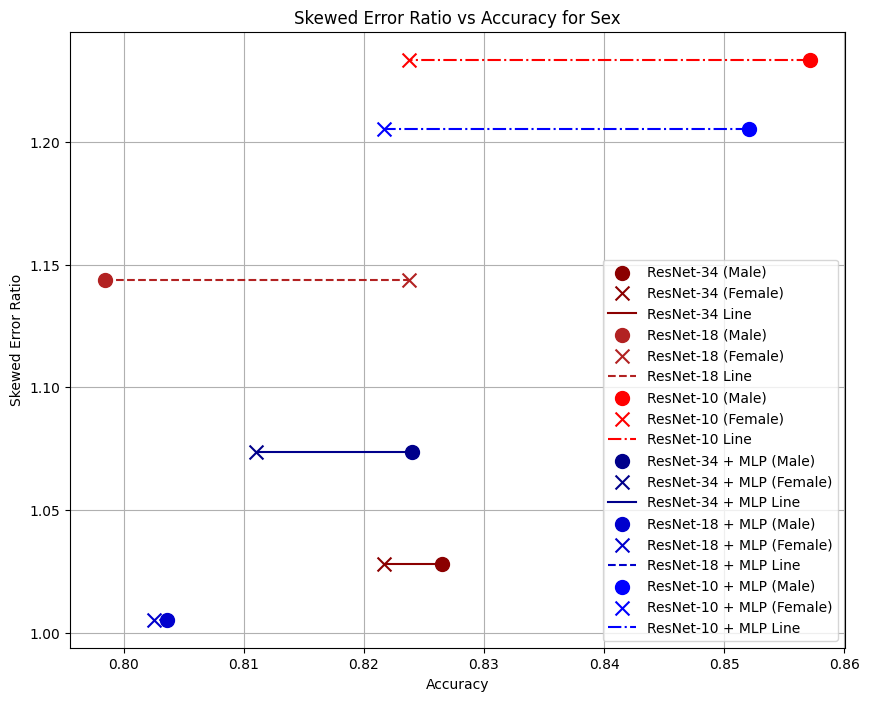

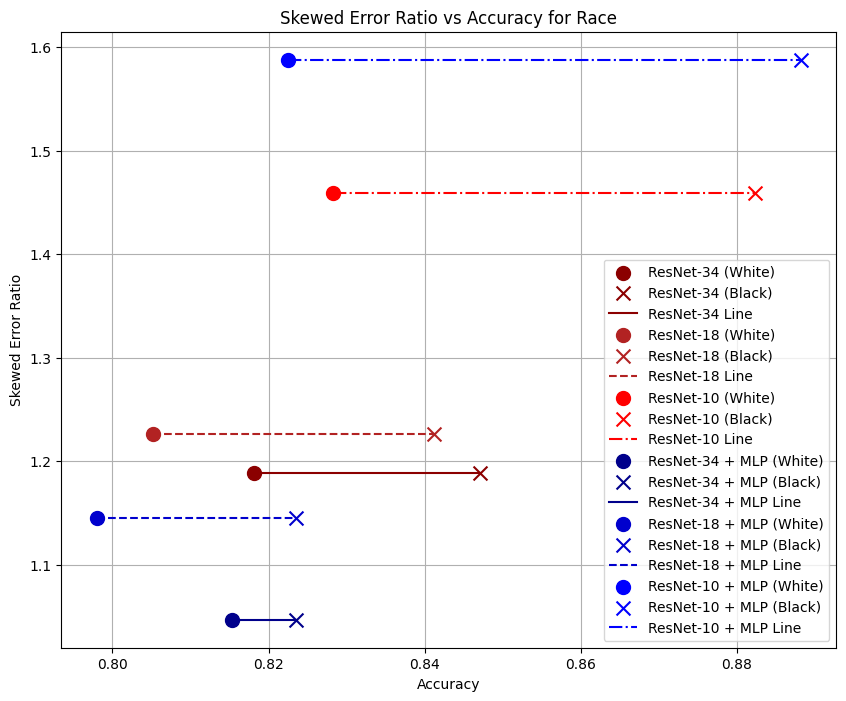

In [17]:
csv_paths = {
    "ResNet-34": "predictions_resnet34.csv",
    "ResNet-18": "predictions_resnet18.csv",
    "ResNet-10": "predictions_resnet10.csv",
    "ResNet-34 + MLP": "predictions_mlp_resnet34.csv",
    "ResNet-18 + MLP": "predictions_mlp_resnet18.csv",
    "ResNet-10 + MLP": "predictions_mlp_resnet10.csv",
}

line_styles = {
    "ResNet-34": "-",
    "ResNet-18": "--",
    "ResNet-10": "-.",
}

def extract_metrics(data, group_key, fairness_metric, performance_metric):
    subgroup_data = data["Grouped metrics"][group_key]
    metric_1 = subgroup_data[1.0][performance_metric]
    fairness_1 = data["Fairness"][group_key][fairness_metric]

    metric_2 = subgroup_data[2.0][performance_metric]
    fairness_2 = data["Fairness"][group_key][fairness_metric]

    return {
        1.0: {"metric": metric_1, "fairness": fairness_1},
        2.0: {"metric": metric_2, "fairness": fairness_2},
    }

def plot_all_models(csv_paths, group_key, group_labels, performance_metric, fairness_metric, title_suffix, output_file):
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ["darkred", "firebrick", "red", "darkblue", "mediumblue", "blue"]
    markers = ["o", "x"]

    for idx, (model_name, csv_path) in enumerate(csv_paths.items()):
        data = evaluate_predictions(csv_path)
        metrics = extract_metrics(data, group_key, fairness_metric, performance_metric)

        base_model = model_name.split(" +")[0]
        line_style = line_styles.get(base_model, "-")

        for group, marker, label in zip([1.0, 2.0], markers, group_labels):
            ax.scatter(
                metrics[group]["metric"],
                metrics[group]["fairness"],
                color=colors[idx],
                label=f"{model_name} ({label})",
                s=100,
                marker=marker
            )

        ax.plot(
            [metrics[1.0]["metric"], metrics[2.0]["metric"]],
            [metrics[1.0]["fairness"], metrics[2.0]["fairness"]],
            color=colors[idx],
            linestyle=line_style,
            label=f"{model_name} Line" if "Line" not in model_name else None
        )

    ax.set_xlabel(performance_metric.capitalize())
    ax.set_ylabel(fairness_metric)
    ax.set_title(f"{fairness_metric} vs {performance_metric.capitalize()} for {title_suffix}")
    ax.legend()
    plt.grid(True)
    plt.savefig(output_file, format='png')
    plt.show()

fairness_metric = "Skewed Error Ratio"
performance_metric = "accuracy"

plot_all_models(
    csv_paths,
    "Sex",
    ["Male", "Female"],
    performance_metric,
    fairness_metric,
    "Sex",
    "ser_sex.png"
)

plot_all_models(
    csv_paths,
    "Race",
    ["White", "Black"],
    performance_metric,
    fairness_metric,
    "Race",
    "ser_race.png"
)


In [13]:
csv_path1 = "predictions_resnet10.csv"
csv_path2 = "predictions_mlp_resnet10.csv"
monomodal = evaluate_predictions(csv_path1)
multimodal = evaluate_predictions(csv_path2)


display_metrics(monomodal)

==== Metrics Report ====

Overall Metrics:
  accuracy: 0.8389339513325609
  f1: 0.8389304910487101
  precision: 0.8391941982272361
  recall: 0.8393181500628755

Fairness Metrics:
  Sex:
    Statistical Parity Difference: 0.014244551323714216
    Equal Opportunity Difference: 0.06334005376344087
    Disparate Impact: 0.9714502822405557
    Skewed Error Ratio: 1.2335456475583857
  Race:
    Statistical Parity Difference: 0.17786266021560138
    Equal Opportunity Difference: 0.11100022177866498
    Disparate Impact: 0.7200309978087756
    Skewed Error Ratio: 1.4595959595959593

Grouped Metrics:
  Sex:
    Group 2.0:
      accuracy: 0.8237791932059448
      f1: 0.8234608767120812
      precision: 0.8238730616660657
      recall: 0.8263444767441861
      TPR: 0.796875
      FPR: 0.14418604651162792
      Positive Rate: 0.4989384288747346
    Group 1.0:
      accuracy: 0.8571428571428571
      f1: 0.8569044639132248
      precision: 0.8566961959353829
      recall: 0.8572919929011379
      T

In [14]:
csv_path1 = "predictions_resnet18.csv"
csv_path2 = "predictions_mlp_resnet18.csv"
monomodal = evaluate_predictions(csv_path1)
multimodal = evaluate_predictions(csv_path2)


display_metrics(monomodal)

==== Metrics Report ====

Overall Metrics:
  accuracy: 0.8122827346465817
  f1: 0.8122703834998388
  precision: 0.8124019765818026
  recall: 0.8125665029395643

Fairness Metrics:
  Sex:
    Statistical Parity Difference: 0.025288140734000597
    Equal Opportunity Difference: 0.008988575268817245
    Disparate Impact: 0.9501643753735804
    Skewed Error Ratio: 1.1436255224981564
  Race:
    Statistical Parity Difference: 0.18085901027077506
    Equal Opportunity Difference: 0.10418052783322251
    Disparate Impact: 0.7179263142565894
    Skewed Error Ratio: 1.2265512265512264

Grouped Metrics:
  Sex:
    Group 2.0:
      accuracy: 0.8237791932059448
      f1: 0.8233204528506541
      precision: 0.8232037224065791
      recall: 0.8255995639534883
      TPR: 0.8046875
      FPR: 0.15348837209302327
      Positive Rate: 0.5074309978768577
    Group 1.0:
      accuracy: 0.798469387755102
      f1: 0.7980896495517522
      precision: 0.797938332421091
      recall: 0.7983348992587953
      T

In [12]:
csv_path1 = "predictions_resnet34.csv"
csv_path2 = "predictions_mlp_resnet34.csv"
monomodal = evaluate_predictions(csv_path1)
multimodal = evaluate_predictions(csv_path2)


display_metrics(monomodal)

==== Metrics Report ====

Overall Metrics:
  accuracy: 0.8238702201622248
  f1: 0.82386809173425
  precision: 0.8241796320969613
  recall: 0.8242737072903343

Fairness Metrics:
  Sex:
    Statistical Parity Difference: 0.06821136097751201
    Equal Opportunity Difference: 0.020707325268817245
    Disparate Impact: 0.8694001991040319
    Skewed Error Ratio: 1.028100412139378
  Race:
    Statistical Parity Difference: 0.19395637042695868
    Equal Opportunity Difference: 0.10745176314038585
    Disparate Impact: 0.7002492457037911
    Skewed Error Ratio: 1.1888111888111883

Grouped Metrics:
  Sex:
    Group 2.0:
      accuracy: 0.821656050955414
      f1: 0.8208801159000363
      precision: 0.8203523035230352
      recall: 0.822156613372093
      TPR: 0.81640625
      FPR: 0.17209302325581396
      Positive Rate: 0.5222929936305732
    Group 1.0:
      accuracy: 0.826530612244898
      f1: 0.8256410256410256
      precision: 0.8269452903496797
      recall: 0.8250339283850088
      TPR: 

In [ ]:
display_metrics(multimodal)

==== Metrics Report ====

Overall Metrics:
  accuracy: 0.816917728852839
  f1: 0.8167875953993335
  precision: 0.8168311509600292
  recall: 0.8167528293977924

Fairness Metrics:
  Sex:
    Statistical Parity Difference: 0.03121344079032884
    Equal Opportunity Difference: 0.02620967741935487
    Disparate Impact: 0.9409577083845587
    Skewed Error Ratio: 1.0735099541524356
  Race:
    Statistical Parity Difference: 0.15044563279857393
    Equal Opportunity Difference: 0.04973386560212911
    Disparate Impact: 0.7631874298540966
    Skewed Error Ratio: 1.0466570466570464

Grouped Metrics:
  Sex:
    Group 2.0:
      accuracy: 0.8110403397027601
      f1: 0.8100505245032512
      precision: 0.8095625746228156
      recall: 0.8109011627906977
      TPR: 0.8125
      FPR: 0.19069767441860466
      Positive Rate: 0.5286624203821656
    Group 1.0:
      accuracy: 0.8239795918367347
      f1: 0.8238408784509876
      precision: 0.8238578680203046
      recall: 0.8246946445349201
      TPR: 